In [75]:
import MDAnalysis
import numpy as np
from DEERPREdict.PRE import PREpredict
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import minimize_scalar, least_squares

In [76]:
!mkdir calcPREs
!mkdir figs

mkdir: calcPREs: File exists


Example of how to run PREpredict to calculate the intensity ratios and PRE rates for PDB code 1NTI (20 conformations) using the rotamer-library approach (`Cbeta = False`).

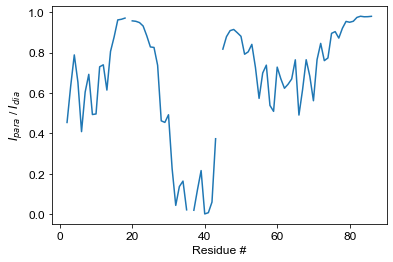

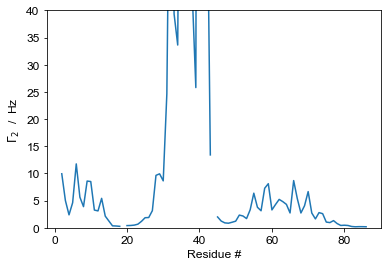

In [92]:
PRE = PREpredict(MDAnalysis.Universe('1nti.pdb'), residue = 36,
      tau_t = .5*1e-9, log_file = 'calcPREs/log', temperature = 298, z_cutoff = 0.05,
      atom_selection = 'H', Cbeta = False)
PRE.run(output_prefix = 'calcPREs/res', tau_t = .5*1e-9,delay = 10e-3,
        tau_c = 2*1e-09,r_2 = 10, wh = 750)

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 12})

resnums, PREratios, PRErates = np.loadtxt('calcPREs/res-{:d}.dat'.format(36),unpack=True)
plt.plot(resnums, PREratios)
plt.ylabel('$I_{para}$ / $I_{dia}$')
plt.xlabel('Residue #')
plt.show()

plt.plot(resnums, PRErates)
plt.ylabel('$\Gamma_2$  /  Hz')
plt.xlabel('Residue #')
plt.ylim(0,40)
plt.show()

Predict PRE intensity ratios of ACBP from PDB code 1NTI using the rotamer library approach RLA and approximating the position of the electron to the C$\beta$ coordinates.

In [78]:
u = MDAnalysis.Universe('1nti.pdb')
u.select_atoms('name {} and protein'.format('N'))

<AtomGroup with 86 atoms>

In [79]:
%%timeit
calcIratio(2,[u, 17, 0.2, 12.6, False])

435 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
def load_calcPREs(path,labels):
    data = {}
    for label in labels:
        resnums, data[label], _ = np.loadtxt(path+'/res-{:d}.dat'.format(label),unpack=True)
    df = pd.DataFrame(data, index=resnums)
    df.rename_axis('residue', inplace=True)
    df.rename_axis('label', axis='columns',inplace=True)
    return resnums, df

def calcIratio(tau_c,args,load_file=False,z_cutoff=0.05):
    u, label, tau_t, r_2, Cbeta = args
    PRE = PREpredict(u, label,  log_file = 'calcPREs/log', temperature = 298, Cbeta = Cbeta, 
                     Z_cutoff = 0.2, atom_selection = 'H', z_cutoff=z_cutoff)
    load_file = 'calcPREs/res-{:d}.pkl'.format(label) if load_file else load_file
    PRE.run(output_prefix = 'calcPREs/res', load_file = load_file, tau_t = tau_t*1e-9, delay = 10e-3,
          tau_c = tau_c*1e-09, r_2 = r_2, wh = 750)
    calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]

In [81]:
labels = [17,36,46,65,86]

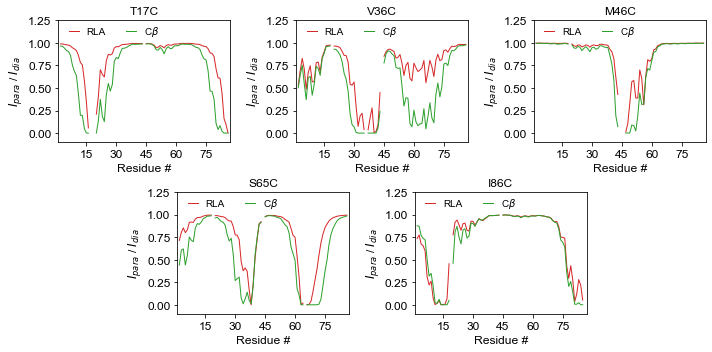

In [82]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=plt.figure(figsize=(10,5)))
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

axes = [ax1,ax2,ax3,ax4,ax5]

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 10})

for ax,label,res in zip(axes,labels,'TVMSI'):
    calcIratio(2,[u, label, 0.2, 12.6, False])
    calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
    ax.plot(resnums, calcPREs, color=plt.cm.tab10(3),lw=1,label='RLA')
    calcIratio(2,[u, label, 0.2, 12.6, True])
    calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
    ax.plot(resnums, calcPREs, color=plt.cm.tab10(2),lw=1,label=r'C$\beta$')
    ax.set_ylabel('$I_{para}$ / $I_{dia}$')
    ax.set_ylim(-.1,1.25)
    ax.set_xlim(1,resnums.size+1)
    ax.set_xticks(range(0,resnums.size+1,15)[1:])
    ax.set_xlabel('Residue #')
    ax.set_title(res+str(label)+'C',fontsize=12)
    ax.legend(frameon=False,handlelength=1,ncol=2,
              loc=(.06,.85),columnspacing=2,borderpad=0)
plt.tight_layout(w_pad=1.5,h_pad=0.5)

Test DEER-PREdict against reference PRE data.

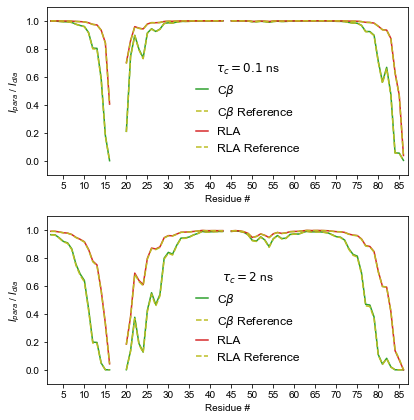

In [83]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(6,6))

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 12})

label=17

calcIratio(0.1,[u, label, 0.1, 12.6, True])
calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(2), label=r'C$\beta$')

calcPREs = np.loadtxt('precalcPREs/PRE_1nti_0.1-{:d}_CB.dat'.format(label))[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'C$\beta$ Reference')

calcIratio(0.1,[u, label, 0.1, 12.6, False])
calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(3), label='RLA')

calcPREs = np.loadtxt('precalcPREs/PRE_1nti_0.1-{:d}.dat'.format(label))[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'RLA Reference')

ax1.legend(frameon=False,title=r'$\tau_c=0.1$ ns',handlelength=1,loc=(.4,.1))

calcIratio(2,[u, label, 0.5, 12.6, True])
calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(2), label=r'C$\beta$')

calcPREs = np.loadtxt('precalcPREs/PRE_1nti_2-{:d}_CB.dat'.format(label))[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'C$\beta$ Reference')

calcIratio(2,[u, label, 0.5, 12.6, False])
calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(3), label='RLA')

calcPREs = np.loadtxt('precalcPREs/PRE_1nti_2-{:d}.dat'.format(label))[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'RLA Reference')

ax2.legend(frameon=False,title=r'$\tau_c=2$ ns',handlelength=1,loc=(.4,.1))

for ax in [ax1,ax2]:
    ax.set_ylabel('$I_{para}$ / $I_{dia}$')
    ax.set_ylim(-.1,1.1)
    ax.set_xlim(1,resnums.size+1)
    ax.set_xticks(range(0,resnums.size+1,5)[1:])
    ax.set_xlabel('Residue #')
plt.tight_layout(h_pad=1)

Reproduce Figure S2 of "DEER-PREdict: Software for Efficient Calculation of Spin-Label EPR and NMR Data from Conformational Ensembles" by Tesei and coworkers.

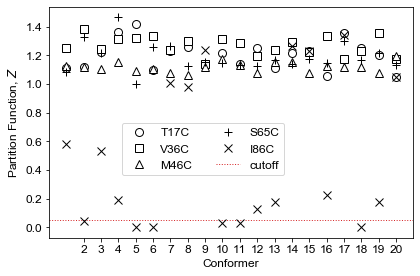

In [72]:
fig = plt.figure(figsize=(6,4))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 12})
for label,res,m in zip(labels,'TVMSI','os^+x'):
    z = np.loadtxt('calcPREs/res-Z-{:d}.data'.format(label))
    plt.plot(range(1,21),z,marker=m,lw=0,color='k',ms=8,mfc='w',label=res+str(label)+'C')
plt.xticks(range(2,21,1),['{:d}'.format(i) for i in range(2,21,1)])
plt.hlines(0.05,0,21,ls=':',lw=1,color=plt.cm.tab10(3),label='cutoff')
plt.legend(ncol=2,loc=(.2,.27))
plt.xlim(0,21)
plt.xlabel('Conformer')
plt.ylabel('Partition Function, $Z$')
plt.tight_layout()